In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import data
from hyperparameters import SimArgs
from parameters import weight_generation, weight_generation_r1, tau_generation
from jax.example_libraries import optimizers
from utils import run_batch, train, inference, prediction_jv_r1
import utils
import os
# check gpu with jax
print(jax.devices())
first_exec = True

[CpuDevice(id=0)]


I0000 00:00:1715265627.065194       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
import sys
print(sys.executable)  # Shows the path to the Python interpreter
print(sys.version)     # Shows the Python version

/Users/tristantorchet/Desktop/SNN/SNN_venv/bin/python3
3.10.2 (main, Sep 28 2023, 20:12:42) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [3]:
save_cm = True
save_vmem = True
save_raster = True
save_results = True
save_w = False

bias_enable = True

args = SimArgs(
    n_in=700,
    n_h=256,
    bias_enable=bias_enable,
    train_tau=True,
    seed=42,
    tau_mem=20e-3,
    tau_syn=10e-3,
    nb_epochs=13,
    lr=0.001,
)
args.pos_w = False

In [4]:
train_loader, val_loader, test_loader = data.get_data_loaders(args)
in_spikes_test_batch0, gt_labels_test_batch0 = next(iter(test_loader))
print(f'{in_spikes_test_batch0.shape=}, {gt_labels_test_batch0.shape=}')
print(f'We will vmap on the first dimension, so each thread will process one sample of size {in_spikes_test_batch0.shape[1:]}')
print(f'We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size {in_spikes_test_batch0.shape[2]}')

datasets:
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_train.h5
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_test.h5
in_spikes_test_batch0.shape=(64, 150, 700), gt_labels_test_batch0.shape=(64,)
We will vmap on the first dimension, so each thread will process one sample of size (150, 700)
We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size 700


In [5]:
@jax.custom_jvp
def gr_than(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)


@gr_than.defjvp
def gr_jvp(primals, tangents):
    """ Surrogate gradient function for thresholding. """
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
    return primal_out, tangent_out

def lif_recurrent(state, input_spikes):
    global args
    ''' Vectorized Recurrent Leaky Integrate and Fire (LIF) neuron model
    '''
    beta_o, v_th, alpha_o = state[1] 
    print(f'{args.bias_enable=}')
    if args.bias_enable:
        ([Win, Wrec, Wout, Wb, beta_h, alpha_h], (i_h, v_h, z_h), (i, v, z)) = state[0]
    else:
        ([Win, Wrec, Wout, beta_h, alpha_h], (i_h, v_h, z_h), (i, v, z)) = state[0]
    i_h = jnp.dot(Win, input_spikes) + jnp.dot(Wrec, z_h) + alpha_h * i_h
    if args.bias_enable:
        i_h += Wb

    v_h = beta_h * v_h + i_h - z_h * v_th
    v_h = jnp.maximum(0, v_h)
    z_h = gr_than(v_h, v_th)
    i = jnp.dot(Wout, z_h) + alpha_o * i
    v = beta_o * v + i - z * v_th
    v = jnp.maximum(0, v)
    z = gr_than(v, v_th)
    if args.bias_enable:
        return (([Win, Wrec, Wout, Wb, beta_h, alpha_h], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)
    else:
        return (([Win, Wrec, Wout, beta_h, alpha_h], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)

utils.lif_recurrent = lif_recurrent   

In [9]:
key = jax.random.PRNGKey(args.seed)
key, w = weight_generation_r1(key, args, bias_enable=args.bias_enable)
log_params = f'{w[0].shape=} (in), {w[1].shape=} (rec), {w[2].shape=} (out)'
if args.bias_enable: 
    log_params += f', {w[-1].shape=} (bias)' 

key, beta_h = tau_generation(key, tau_bar=args.tau_mem, layer_size=args.n_h, dt=args.timestep)
w.append(beta_h)
log_params += f', {beta_h.shape=} (tau_mem_h)'

key, alpha_h = tau_generation(key, tau_bar=args.tau_syn, layer_size=args.n_h, dt=args.timestep)
w.append(alpha_h)
log_params += f', {alpha_h.shape=} (tau_syn_h)'

beta_o = float(jnp.exp(-args.timestep/args.tau_mem))
alpha_o = float(jnp.exp(-args.timestep/args.tau_syn))

hp = (beta_o, args.v_thr, alpha_o)
print(f'{len(hp)=}')
print(log_params)
print(f'{len(w)=}')

len(hp)=3
w[0].shape=(256, 700) (in), w[1].shape=(256, 256) (rec), w[2].shape=(20, 256) (out), w[-1].shape=(256,) (bias), beta_h.shape=(256,) (tau_mem_h), alpha_h.shape=(256,) (tau_syn_h)
len(w)=6


In [10]:
w_init = w

In [8]:
opt_init, opt_update, get_params = optimizers.adam(step_size=args.lr)
opt_state = opt_init(w)

for i in range(5):

    (batch_loss, batch_acc), grads = run_batch(w, hp, test_loader)
    opt_state = opt_update(i, grads, opt_state)
    w = get_params(opt_state)
    w[3] = jnp.clip(w[3], a_min=3*args.timestep, a_max=-3/jnp.log(0.995))




args.bias_enable=True


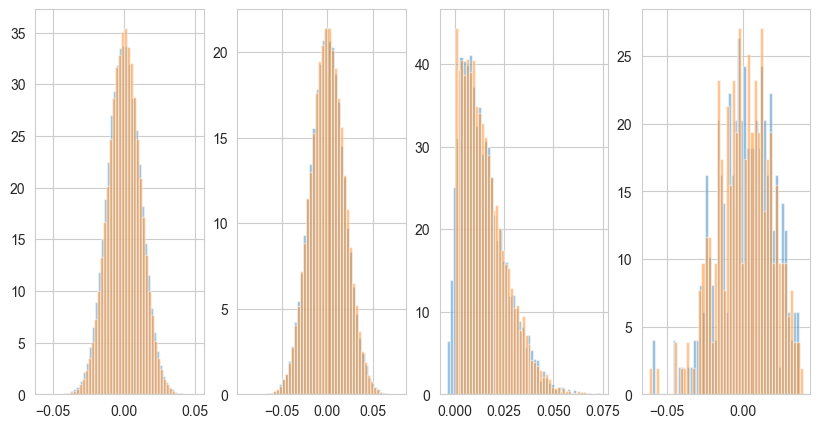

In [9]:
# plot tau_mem_h
import matplotlib.pyplot as plt
w = get_params(opt_state)
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].hist(w[0].flatten(), bins=50, density=True, alpha=0.5)
ax[1].hist(w[1].flatten(), bins=50, density=True, alpha=0.5)
ax[2].hist(w[2].flatten(), bins=50, density=True, alpha=0.5)
ax[3].hist(w[3].flatten(), bins=50, density=True, alpha=0.5)

ax[0].hist(w_init[0].flatten(), bins=50, density=True, alpha=0.5)
ax[1].hist(w_init[1].flatten(), bins=50, density=True, alpha=0.5)
ax[2].hist(w_init[2].flatten(), bins=50, density=True, alpha=0.5)
ax[3].hist(w_init[3].flatten(), bins=50, density=True, alpha=0.5)

plt.show()

In [11]:
loaders = (train_loader, val_loader, test_loader)
first_exec = True 
if first_exec:
    get_params, opt_state, hist = train(w, hp, loaders, args)
    w = get_params(opt_state)
    print(f'{len(w)=}')
    first_exec = False
    
    if save_w: 
        path_weights = f'trained_w/pn21/r1_TrainedHet/{args.n_h}h_'
        if not os.path.exists(path_weights):
            os.makedirs(path_weights)
        if args.pos_w:
            path_weights += 'posWin_'
        if args.bias_enable:
            path_weights += 'bias_'
        path_weights += f'{args.nb_epochs}e'
        
        jnp.save(f'{path_weights}/win.npy', w[0])
        jnp.save(f'{path_weights}/wrec.npy', w[1])
        jnp.save(f'{path_weights}/wout.npy', w[2])
        
        if args.bias_enable:
            jnp.save(f'{path_weights}/wb.npy', w[3])
            
        jnp.save(f'{path_weights}/beta_h.npy', w[-2])
        jnp.save(f'{path_weights}/alpha_h.npy', w[-1])
       

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
0     |2.7929    |0.1341    |0.1781    |0.1844    |2.5608    |2.5211    
1     |2.3203    |0.2570    |0.3206    |0.3321    |2.1195    |2.0437    
2     |1.7771    |0.4406    |0.4562    |0.4679    |1.6244    |1.6003    
3     |1.4370    |0.5282    |0.5219    |0.5272    |1.3999    |1.3661    
4     |1.2939    |0.5743    |0.5425    |0.5304    |1.3181    |1.3216    
5     |1.1659    |0.6146    |0.5856    |0.5679    |1.2064    |1.2115    
6     |1.0558    |0.6586    |0.6075    |0.5835    |1.1307    |1.1695    
7     |0.9903    |0.6742    |0.6331    |0.5871    |1.0613    |1.1297    
8     |0.9187    |0.6983    |0.6506    |0.6013    |1.0326    |1.1047    
9     |0.8707    |0.7150    |0.6794    |0.6272    |0.9450    |1.0305    
10    |0.8126    |0.7447    |0.6963    |0.6281    |0.9003    |1.0321    
11    |0.7532    |0.7573    |0.7306    |0.6295    |

In [12]:
train_loss, train_acc, _ = inference(w, hp, train_loader)
val_loss, val_acc, _ = inference(w, hp, val_loader)
test_loss, test_acc, (test_lbls, test_preds) = inference(w, hp, test_loader)
print(f'{test_lbls.shape=}')
print(f'{test_loss.mean()=:.4f}, {test_acc.mean()=:.4f}')
test_loss_init, test_acc_init, (test_lbls_init, test_preds_init) = inference(w_init, hp, test_loader)
print(f'{test_loss_init.mean()=:.4f}, {test_acc_init.mean()=:.4f}')

test_lbls.shape=(2240,)
test_loss.mean()=0.9872, test_acc.mean()=0.6290
test_loss_init.mean()=3.0020, test_acc_init.mean()=0.0545


In [14]:
if save_results:
    # create a result folder if it does not exist
    if not os.path.exists('results'):
        os.makedirs('results')
    # open the result file csv
    if not os.path.exists('results/pn21_r1.csv'):
        with open('results/pn21_r1.csv', 'w') as f:
            f.write('val_acc,test_acc,train_acc,val_loss,test_loss,train_loss,'
                    'n_h,nb_epochs,lr,bias_enable,pos_w,tau_mem,tau_syn\n')
    # append the result to the csv file
    with open('results/pn21_r1.csv', 'a') as f:
        f.write(f'{val_acc.mean():.4f},{test_acc.mean():.4f},{train_acc.mean():.4f},'
                f'{val_loss.mean():.4f},{test_loss.mean():.4f},{train_loss.mean():.4f},'
                f'{args.n_h},{args.nb_epochs},{args.lr},{bias_enable},'
                f'{args.pos_w},{args.tau_mem},{args.tau_syn}\n')

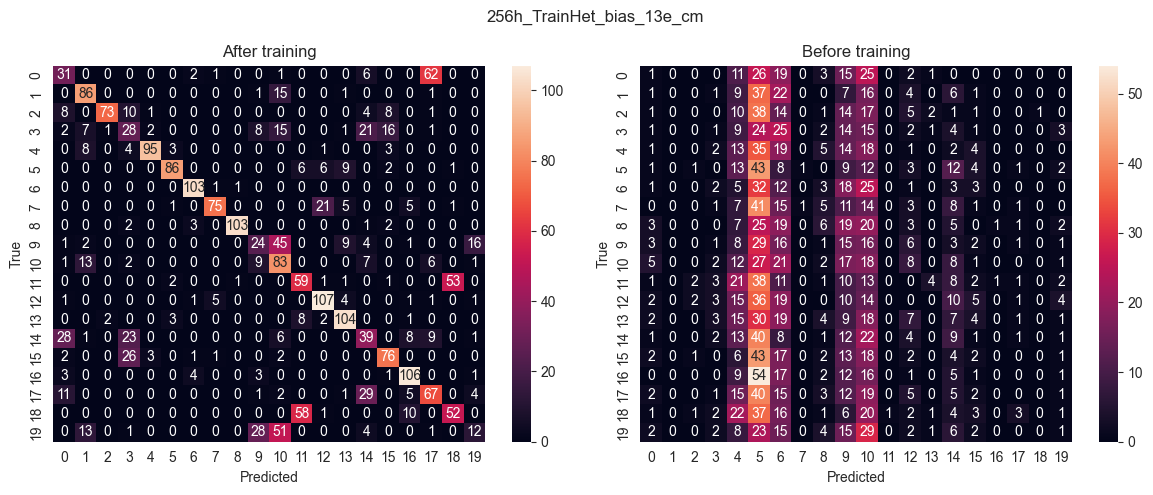

In [21]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_lbls, test_preds)
cm_original = confusion_matrix(test_lbls_init, test_preds_init)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#cm_mask = np.where(cm > 5, 0, 1)
sns.heatmap(cm, annot=True, ax=ax[0], fmt='g')#, mask=cm_mask)
sns.heatmap(cm_original, annot=True, ax=ax[1], fmt='g')
ax[0].set_title('After training')
ax[1].set_title('Before training')
# set x and y labels
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
# save 
path = f'images/pn21/r1'
image_name = 'cm'
prefix = f'{args.n_h}h_TrainHet_'
if args.pos_w:
    prefix += 'posWin_'
if bias_enable:
    prefix += 'bias_'
prefix += f'{args.nb_epochs}e_'
image_name = prefix + image_name
plt.suptitle(image_name)
plt.tight_layout()

if save_cm:
    # check if the folder exists
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{image_name}.png', transparent=False, format='png')

plt.show()


In [11]:
# use sklearn for the classification report
from sklearn.metrics import classification_report
print(classification_report(test_lbls, test_preds))
# print report sorted by f1-score
report = classification_report(test_lbls, test_preds, output_dict=True)
# report as pandas dataframe
import pandas as pd
report = pd.DataFrame(report).T
#sort report by f1
print(report[:20].sort_values('f1-score', ascending=False))

              precision    recall  f1-score   support

           0       0.55      0.34      0.42       103
           1       0.70      0.66      0.68       104
           2       0.94      0.70      0.80       105
           3       0.53      0.49      0.51       102
           4       0.65      0.78      0.71       114
           5       0.76      0.81      0.78       110
           6       0.88      0.95      0.91       105
           7       0.69      0.78      0.73       108
           8       0.85      0.95      0.90       111
           9       0.48      0.45      0.46       102
          10       0.54      0.61      0.57       122
          11       0.78      0.50      0.61       118
          12       0.61      0.70      0.65       121
          13       0.46      0.55      0.50       120
          14       0.88      0.61      0.72       115
          15       0.68      0.68      0.68       111
          16       0.77      0.74      0.75       118
          17       0.38    

In [16]:
zh_init, v_init, z_init = prediction_jv_r1(w_init, hp, in_spikes_test_batch0)
zh, v, z = prediction_jv_r1(w, hp, in_spikes_test_batch0)

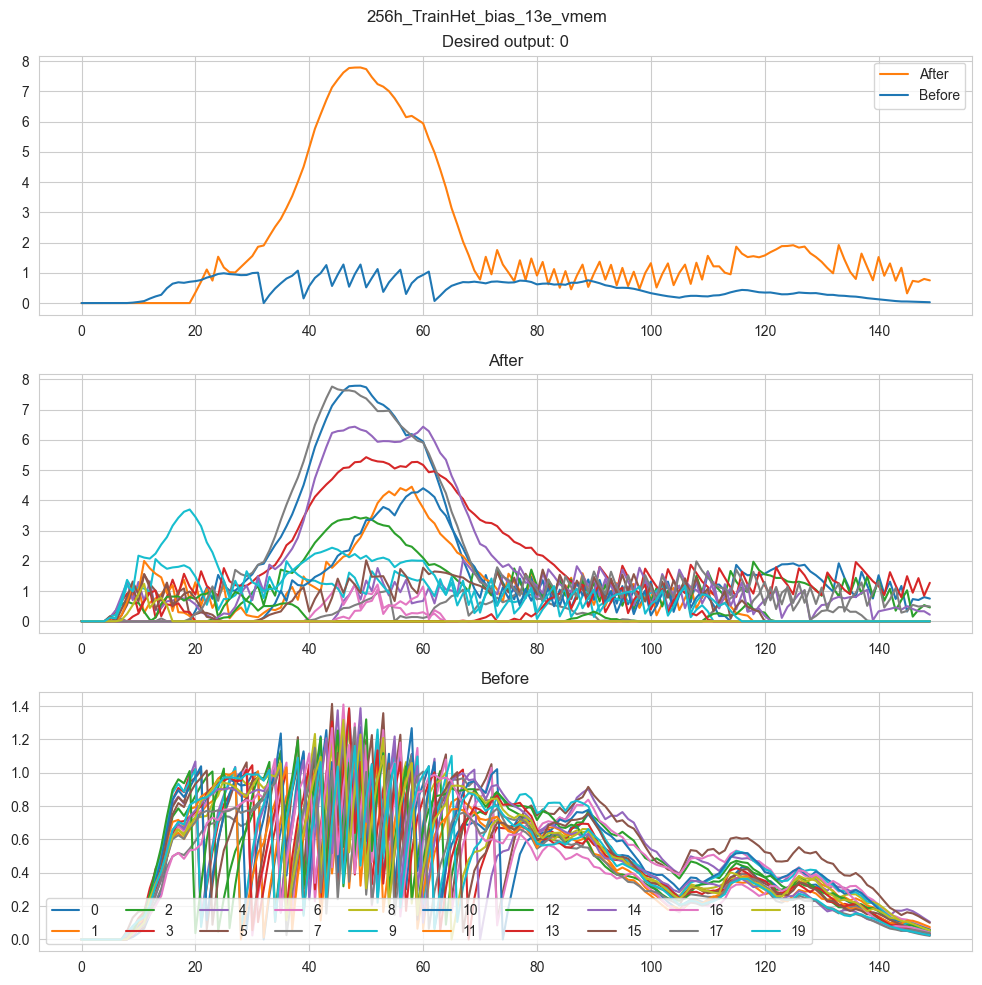

In [17]:
import matplotlib.pyplot as plt
id_sample = 6
v0_init = v_init[id_sample]
v0 = v[id_sample]
# plot the membrane potential of the 20 neurons with 150 timestep 
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

for i in range(20):
    if i == gt_labels_test_batch0[id_sample]:
        ax[0].plot(v0[:, i], label=f'After', color='C1')
        ax[0].plot(v0_init[:, i], label='Before', color='C0')
    ax[1].plot(v0[:, i], label=f'{i}')
    ax[2].plot(v0_init[:, i], label=f'{i}')
titles = [f'Desired output: {gt_labels_test_batch0[id_sample]}', 'After', 'Before']
for i in range(3):
    ax[i].set_title(f'{titles[i]}')
    if i!=1: ax[i].legend()
fig.tight_layout()
plt.legend(ncol=10, loc='lower left')

image_name = 'vmem'
image_name = prefix + image_name
plt.suptitle(f'{image_name}')
plt.tight_layout()

if save_vmem:
    # check if the folder exists
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{image_name}.png', transparent=False, format='png')
plt.show()
        

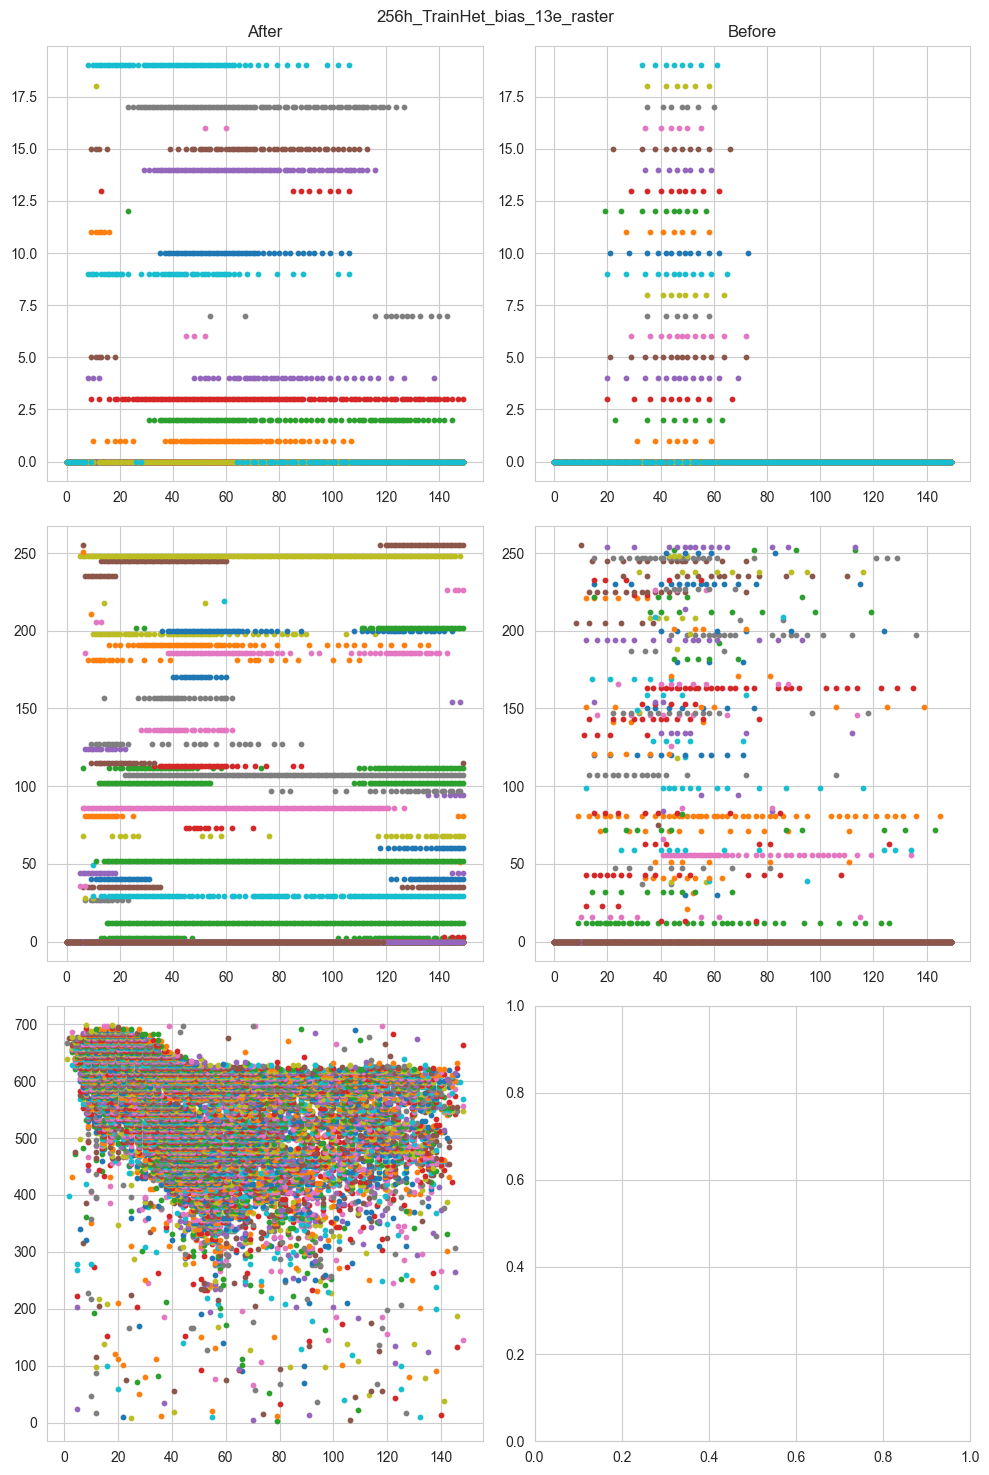

In [18]:
# plot the raster plot of the 20 neurons with 150 timestep

z0 = z[id_sample]
zh0 = zh[id_sample]
z0_init = z_init[id_sample]
zh0_init = zh_init[id_sample]
in_spikes_sample = jnp.where(in_spikes_test_batch0[id_sample] == 0, jnp.nan, 1)
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
t = jnp.arange(150)
for i in range(20):
    ax[0,0].scatter(t, z0[:, i] * i, s=10, label=f'{i}')
    ax[0,1].scatter(t, z0_init[:, i] * i, s=10, label=f'{i}')
for i in range(zh.shape[-1]):
    ax[1,0].scatter(t, zh0[:, i] * i, s=10, label=f'{i}')
    ax[1,1].scatter(t, zh0_init[:, i] * i, s=10, label=f'{i}')
for i in range(in_spikes_sample.shape[-1]):
    ax[2,0].scatter(t, in_spikes_sample[:, i] * i, s=10, label=f'{i}')

image_name = 'raster'
image_name = prefix + image_name
ax[0, 0].set_title('After')
ax[0, 1].set_title('Before')
plt.suptitle(f'{image_name}')
plt.tight_layout()
if save_raster:
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{image_name}.png', transparent=False, format='png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

t = np.arange(150)

fig, axs = plt.subplots(8, 8, figsize=(20, 20))
for i in range(64):
    zh0 = zh[i]
    zh0_pca = pca.fit_transform(zh0)
    x    = zh0_pca[:, 0]
    y    = zh0_pca[:, 1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,len(x))
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[i//8, i%8].add_collection(lc)
    # set x and y limits
    axs[i//8, i%8].set_xlim(-10, 10)
    axs[i//8, i%8].set_ylim(-10, 10)
    # add a title with the label
    axs[i//8, i%8].set_title(f'Label {gt_labels_test_batch0[i]}', y=1, pad=-14)

fig.colorbar(line ,ax=axs[i//8, i%8])

# make the line a gradient of color
# display colorbar
#plt.colorbar()
plt.show()

In [61]:
wrec = w[1]
# compute the rank of wrec
from scipy.linalg import svdvals
print(f'{np.linalg.matrix_rank(wrec)=}')
print(f'{np.linalg.matrix_rank(w_init[1])=}')


np.linalg.matrix_rank(wrec)=256
np.linalg.matrix_rank(wrec_original)=256


In [34]:
# Generate a key
key = jax.random.PRNGKey(1)

# Set the shape parameter 'a'
a = 2.0  # shape parameter, called k in wikipedia

# Optional: define the rate or scale
rate = 1.0
scale = 5.0 # called theta in wikipedia

# Generate gamma distributed samples with unit scale
samples_unit = jax.random.gamma(key, a, shape=(10000,))

# Adjust samples to reflect a specific rate
# samples_rate = samples_unit / rate

# Adjust samples to reflect a specific scale
samples_scale = samples_unit * scale

sample_scale_numpy = np.random.gamma(a, scale, size=(10000,))

a=2.033078840718596, loc=0, scale=4.9880772383923855
a=1.9507247997793213, loc=0, scale=5.133707701955203


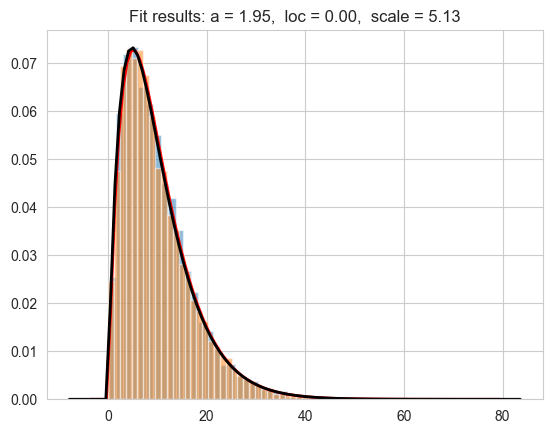

In [35]:
# plot the gamma distribution
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
# generate random numbers from N(0,1)
data = samples_scale
# fit a gamma distribution to the data
a, loc, scale = stats.gamma.fit(data, floc=0)
print(f'{a=}, {loc=}, {scale=}')
# plot the histogram
plt.hist(data, bins=50, density=True, alpha=0.5)
# plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.gamma.pdf(x, a, loc, scale)
plt.plot(x, p, color='red', linewidth=2)

data = sample_scale_numpy
# fit a gamma distribution to the data
a, loc, scale = stats.gamma.fit(data, floc=0)
print(f'{a=}, {loc=}, {scale=}')
# plot the histogram
plt.hist(data, bins=50, density=True, alpha=0.5)
# plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.gamma.pdf(x, a, loc, scale)
plt.plot(x, p, 'k', linewidth=2)    
title = "Fit results: a = %.2f,  loc = %.2f,  scale = %.2f" % (a, loc, scale)
plt.title(title)
plt.show()


a=0.9869283291955543, loc=0, scale=1.0714978075163526
a=1.9580095582863446, loc=0, scale=1.090725702018784
a=2.8426883176188524, loc=0, scale=1.098182613470698
a=3.749454529633862, loc=0, scale=1.0988009078996874
a=4.679559755891875, loc=0, scale=1.0952540139784785
a=1.9580095582863446, loc=0, scale=1.090725702018784
a=1.958010541038585, loc=0, scale=2.181450309137306
a=1.9580089686355044, loc=0, scale=3.2721782132323627
a=1.9580097548367092, loc=0, scale=4.362902370115041
a=1.9580089686355044, loc=0, scale=5.453630761273357


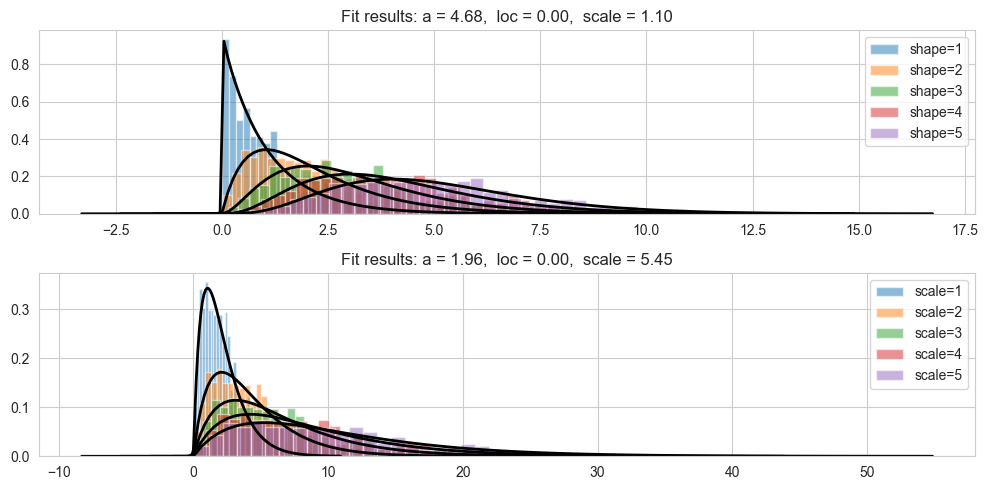

In [29]:
# plot a gamma distribution with different shape parameters
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
# generate random numbers from N(0,1)
shapes = [1, 2, 3, 4, 5]
for id_s, s in enumerate(shapes):
    data = jax.random.gamma(key, s, shape=(1000,))
    # fit a gamma distribution to the data
    a, loc, scale = stats.gamma.fit(data, floc=0)
    print(f'{a=}, {loc=}, {scale=}')
    # plot the histogram
    ax[0].hist(data, bins=50, density=True, alpha=0.5, label=f'shape={s}')
    # plot the PDF
    xmin, xmax = ax[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.gamma.pdf(x, a, loc, scale)
    ax[0].plot(x, p, 'k', linewidth=2)    
    title = "Fit results: a = %.2f,  loc = %.2f,  scale = %.2f" % (a, loc, scale)
    ax[0].set_title(title)
    ax[0].legend()
scales = [1, 2, 3, 4, 5]
for id_sc, sc in enumerate(scales):
    data = jax.random.gamma(key, 2, shape=(1000,)) * sc
    # fit a gamma distribution to the data
    a, loc, scale = stats.gamma.fit(data, floc=0)
    print(f'{a=}, {loc=}, {scale=}')
    # plot the histogram
    ax[1].hist(data, bins=50, density=True, alpha=0.5, label=f'scale={sc}')
    # plot the PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.gamma.pdf(x, a, loc, scale)
    ax[1].plot(x, p, 'k', linewidth=2)    
    title = "Fit results: a = %.2f,  loc = %.2f,  scale = %.2f" % (a, loc, scale)
    ax[1].set_title(title)
    ax[1].legend()
plt.tight_layout()
plt.show()